In [1]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [2]:
def create_server_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [3]:
conn = create_server_connection("localhost", "root", "rootpass", "base_startup")

MySQL Database connection successful


In [4]:
def read_query(connection, query):
    cursor = connection.cursor(buffered=True)
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        from_db = []
        for res in result:
          res = list(res)
          from_db.append(res)
        return result
    except Error as err:
        print(f"Error: '{err}'")

## Data Visualization.

**Sales Increase Year 2023 per Month.**

In [7]:
r = read_query(conn,"SELECT MONTH(start_date) AS Month, SUM(price) AS Price_usd " 
              + "FROM Student_Course AS SC " 
              + "INNER JOIN Course ON SC.id_course = Course.id "
              + "WHERE paid = 1 AND YEAR(start_date) = 2023 "
              + "GROUP BY Month "
              + "ORDER BY Month")
columns = ['Month', 'Price_usd']
df_price = pd.DataFrame(r, columns=columns)

In [8]:
df_price['Price_usd'] = df_price['Price_usd'].astype('Int64')
df_price

,Month,Price_usd
0,1,700
1,2,400
2,3,900
3,4,700
4,5,1400
5,6,1000
6,7,1300
7,8,700


In [9]:
#df_price.dtypes

In [10]:
r = read_query(conn,"SELECT MONTH(start_date) AS Month, SUM(salary)*0.1 AS Salary_income_usd " 
              + "FROM Company_Student " 
              + "WHERE YEAR(start_date) = 2023 "
              + "GROUP BY Month "
              + "ORDER BY Month")
columns = ['Month', 'Salary_income_usd']
df_salary = pd.DataFrame(r, columns=columns)

In [11]:
df_salary['Salary_income_usd'] = df_salary['Salary_income_usd'].astype('Int64')
df_salary

,Month,Salary_income_usd
0,1,265
1,2,175
2,3,450
3,4,395
4,5,320
5,6,475
6,7,280
7,8,410


In [12]:
#df_price.dtypes

In [13]:
df_total = pd.merge(df_salary, df_price, on=['Month'], how='left')

In [14]:
df_total = df_total.fillna(0)

In [15]:
df_total

,Month,Salary_income_usd,Price_usd
0,1,265,700
1,2,175,400
2,3,450,900
3,4,395,700
4,5,320,1400
5,6,475,1000
6,7,280,1300
7,8,410,700


In [16]:
df_total['Total_Sales'] = df_total['Price_usd'] + df_total['Salary_income_usd']
df_total = df_total.loc[:, ['Month', 'Total_Sales']]

In [17]:
df_total

,Month,Total_Sales
0,1,965
1,2,575
2,3,1350
3,4,1095
4,5,1720
5,6,1475
6,7,1580
7,8,1110


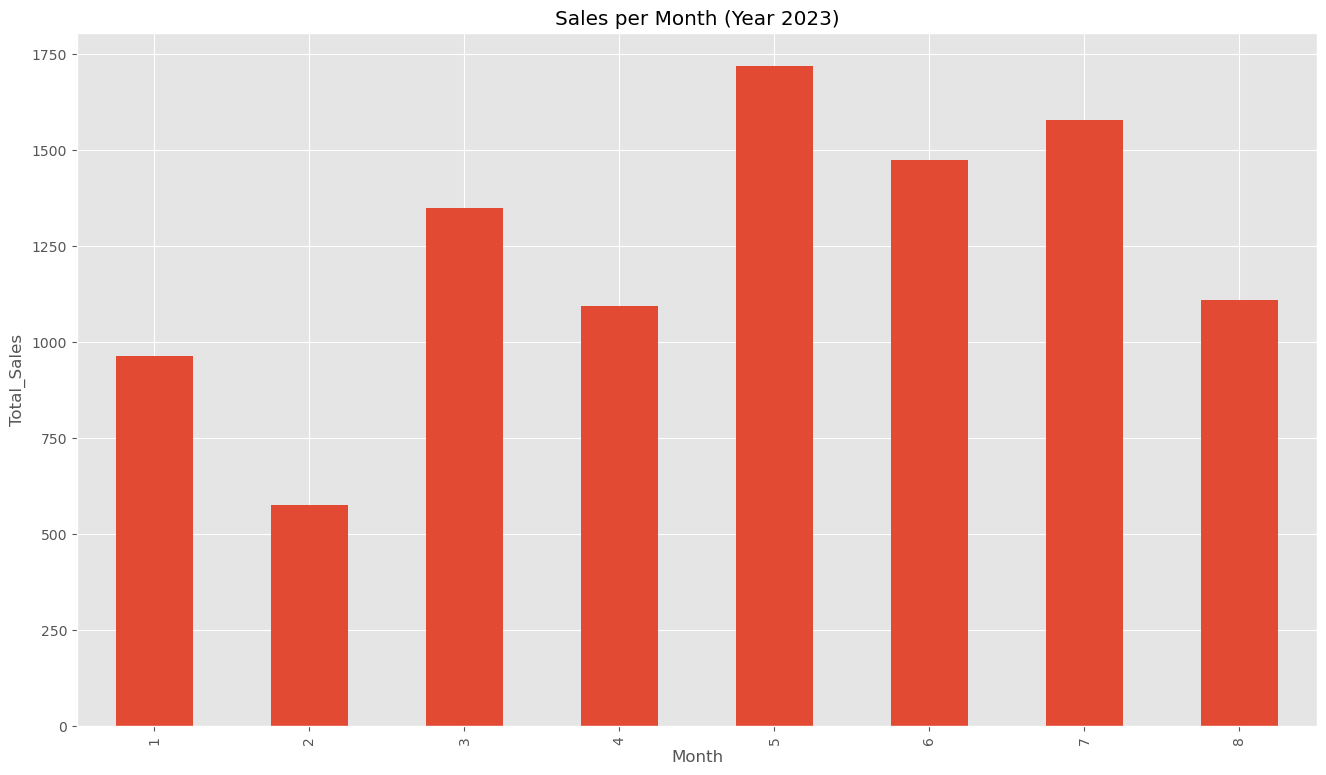

In [18]:
df_total.groupby(by=['Month'])['Total_Sales'].sum().plot(kind='bar',ylabel='Total_Sales',title='Sales per Month (Year 2023)');

**Quantity Students per Quintil and Month in Year 2023.**

In [31]:
r = read_query(conn,"SELECT MONTH(start_date) AS Initial_Month, quintile AS Quintil, COUNT(DISTINCT Student.id) AS Q_students " 
              + "FROM Student " 
              + "INNER JOIN Student_Course AS SC ON Student.id = SC.id_student "
              + "WHERE YEAR(start_date) = 2023 "
              + "GROUP BY Initial_Month, Quintil "
              + "ORDER BY Initial_Month")
columns = ['Initial_Month', 'Quintil', 'Q_students']
df_students = pd.DataFrame(r, columns=columns)

In [32]:
df_students

,Initial_Month,Quintil,Q_students
0,1,1,4
1,1,2,4
2,1,3,1
3,1,4,1
4,1,5,1
5,2,1,3
6,2,3,3
7,2,4,3
8,2,5,2
9,3,1,2


In [33]:
## Transpose table for the graphic.

df_students = df_students.reset_index()
df_students = df_students.pivot_table(values = ['Q_students'], index = ['Initial_Month'], columns=['Quintil'], aggfunc= np.sum)
df_students

Q_students                    
Quintil                1    2    3    4    5
Initial_Month                               
1                    4.0  4.0  1.0  1.0  1.0
2                    3.0  NaN  3.0  3.0  2.0
3                    2.0  3.0  NaN  2.0  2.0
4                    4.0  2.0  1.0  4.0  1.0
5                    7.0  3.0  1.0  4.0  2.0
6                    2.0  NaN  4.0  NaN  3.0
7                    2.0  NaN  4.0  3.0  4.0
8                    1.0  1.0  3.0  1.0  3.0

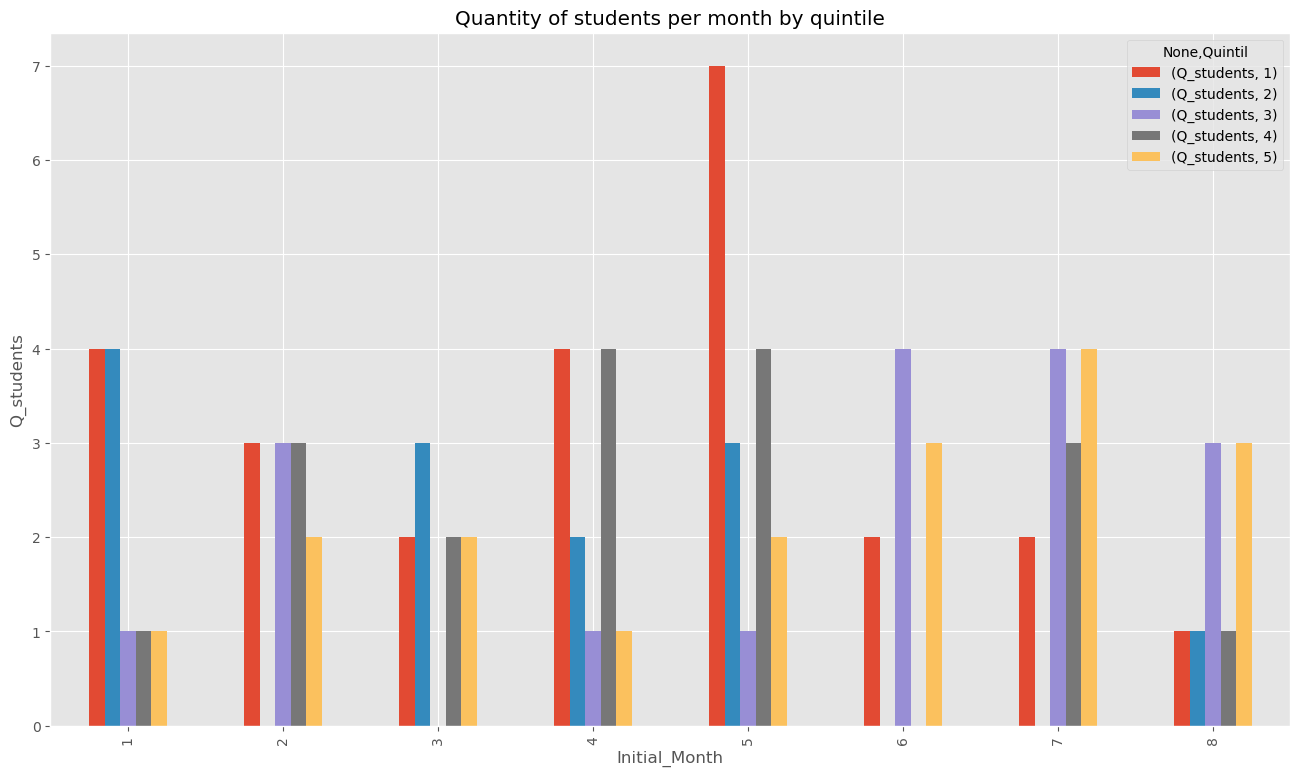

In [34]:
df_students.plot(kind = 'bar', ylabel = 'Q_students', title = 'Quantity of students per month by quintile');

## Segmentation Model.

**K-means Model.**

In [20]:
## Import dataframe to use

r = read_query(conn,"SELECT * " 
              + "FROM Student") 
columns = ['id', 'last_name', 'first_name', 'join_date', 'age', 'birthdate', 'country', 'quintile', 'email', 'incomemonth']
df_students = pd.DataFrame(r, columns=columns)

In [21]:
df_students

,id,last_name,first_name,join_date,age,birthdate,country,quintile,email,incomemonth
0,1,Walker,Chase,2022-08-27,32,1990-10-19,PR,4,verda92@example.org,607
1,2,Heidenreich,Leslie,2023-06-27,36,1986-10-11,PE,3,emard.aisha@example.org,305
2,3,West,Lorenzo,2023-02-18,33,1990-08-14,AR,5,yboyle@example.net,1286
3,4,Doyle,Kasey,2022-12-03,32,1990-11-22,PE,1,mayer.dewayne@example.net,104
4,5,Stokes,Connor,2022-08-27,42,1980-09-25,CL,2,gayle.mosciski@example.net,234
...,...,...,...,...,...,...,...,...,...,...
95,96,McDermott,Anastasia,2023-05-11,44,1978-12-28,CL,4,hferry@example.org,550
96,97,Crist,Filiberto,2023-05-07,43,1980-08-30,CL,5,torrance.bartell@example.net,1712
97,98,Koelpin,Elissa,2022-12-29,28,1995-06-22,MX,3,djacobson@example.net,351
98,99,Bauch,Orlo,2023-06-04,52,1971-07-04,AR,5,ankunding.orville@example.com,1672


In [22]:
df_students.describe()

,id,age,incomemonth
count,100.000000,100.0000,100.000000
mean,50.500000,38.2000,505.980000
std,29.011492,8.3666,444.782843
min,1.000000,21.0000,100.000000
25%,25.750000,32.0000,197.000000
50%,50.500000,38.0000,331.500000
75%,75.250000,45.0000,641.000000
max,100.000000,52.0000,1933.000000


In [23]:
df_students_filter = df_students.loc[: , ['id', 'age', 'quintile', 'incomemonth']]

In [24]:
X = df_students_filter.loc[: , ['age', 'incomemonth']]
y = df_students_filter.loc[: ,['quintile']]

**Obtain best number of clusters.**

/Users/javierajauregui/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/javierajauregui/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/javierajauregui/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/javierajauregui/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

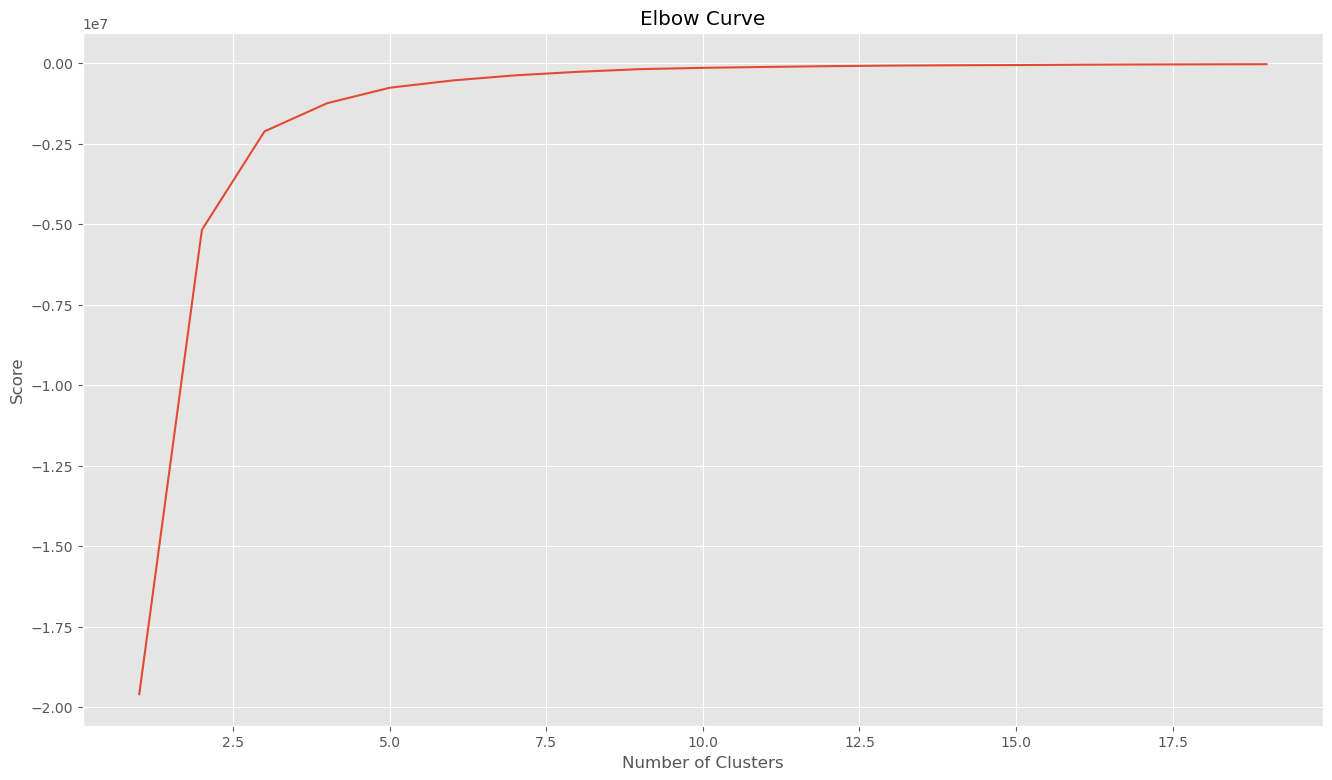

In [25]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters = i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The curve tends to stabilize at 5, therefore, 5 will be used as the recommended number of clusters.

In [26]:
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_
centroids

/Users/javierajauregui/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[  37.6122449 ,  198.48979592],
       [  43.28571429, 1704.85714286],
       [  38.71428571,  732.57142857],
       [  37.09090909,  431.63636364],
       [  39.5       , 1148.25      ]])

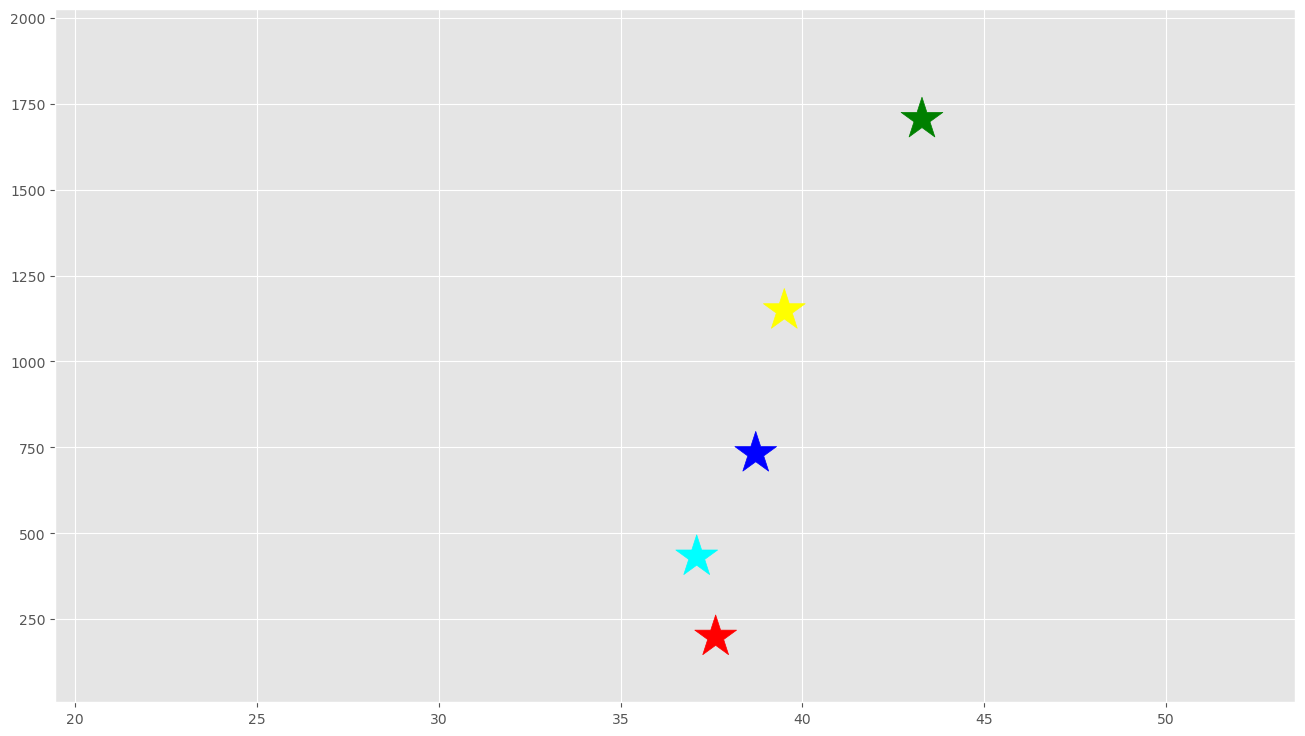

In [27]:
# Predicting the clusters
labels = kmeans.predict(X)

# Getting the cluster centers
C = kmeans.cluster_centers_
colores = ['red','green','blue','cyan','yellow']
asignar = []

f1 = df_students_filter['age'].values
f2 = df_students_filter['incomemonth'].values
 
plt.scatter(f1, f2, c = asignar, s = 70)
plt.scatter(C[:, 0], C[:, 1], marker = '*', c = colores, s = 1000)
plt.show()

**Number of Students per Group.**

In [28]:
copy = pd.DataFrame()
copy['student'] = df_students_filter['id'].values
copy['quintile'] = df_students_filter['quintile'].values
copy['label'] = labels;
cantidadGrupo = pd.DataFrame()
cantidadGrupo['color'] = colores
cantidadGrupo['cantidad'] = copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,49
1,green,7
2,blue,14
3,cyan,22
4,yellow,8
